# Sentiment based content-based recommendation system

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity

train_df = pd.read_csv("D:/Master/FSS_25/Web_Mining/Project/data/train_wide.csv")
beers_df = pd.read_csv("D:/Master/FSS_25/Web_Mining/Project/data/cleaned_beers.csv")

train_df

,username,beer_id,feel_predicted_rating,look_predicted_rating,smell_predicted_rating,taste_predicted_rating,feel_true_rating,look_true_rating,smell_true_rating,taste_true_rating
0,2beerdogs,286475,3.820000,3.790000,3.820000,3.840000,3.500000,3.750000,3.750000,3.500000
1,scootny,138765,3.940000,3.930000,3.940000,3.940000,4.000000,3.625000,4.000000,4.125000
2,Boilermaker88,2280,2.054000,2.043250,2.055000,2.063250,1.987500,2.300000,1.525000,1.518750
3,altgeeky1,25007,2.377692,2.352308,2.366154,2.377692,2.423077,2.807692,1.769231,1.884615
4,draheim,46983,3.997500,3.957500,4.007500,4.005000,3.937500,4.187500,4.187500,4.250000
...,...,...,...,...,...,...,...,...,...,...
21470,metter98,51153,4.043333,4.040000,4.060000,4.046667,4.083333,4.000000,4.416667,4.333333
21471,Gunslinger711,34146,3.844737,3.828947,3.843158,3.845789,3.921053,3.868421,3.934211,4.052632
21472,BEERchitect,9613,3.070000,3.010000,3.040000,3.040000,3.000000,3.250000,3.250000,3.000000
21473,budgood1,31057,1.510000,1.530000,1.520000,1.550000,1.500000,1.250000,1.500000,1.500000


In [10]:
beers_df

,id,style,availability,country,abv,retired
0,8704,American Adjunct Lager,Year-round,CO,4.00,f
1,50819,American Adjunct Lager,Year-round,CA,5.00,f
2,3474,American Adjunct Lager,Year-round,US,5.90,f
3,26195,American Adjunct Lager,Year-round,SV,3.70,f
4,36940,American Adjunct Lager,Year-round,US,5.20,f
...,...,...,...,...,...,...
5530,159363,Winter Warmer,Fall,GB,6.00,f
5531,107195,Winter Warmer,Winter,US,9.00,f
5532,175535,Winter Warmer,Winter,PT,6.60,f
5533,54221,Winter Warmer,Winter,US,8.75,f


In [ ]:
# Merge train and beers data
beers_df = beers_df.rename(columns={'id': 'beer_id'})
train_merged = train_df.merge(beers_df, on='beer_id', how='left')

In [ ]:
# Select columns used for feature engineering
categorical_cols = ['style', 'availability', 'country']
numerical_cols = ['abv', 'feel_predicted_rating', 'look_predicted_rating', 
                  'smell_predicted_rating', 'taste_predicted_rating']

# Remove samples with missing values
train_merged = train_merged.dropna(subset=categorical_cols + numerical_cols)

# One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
categorical_features = encoder.fit_transform(train_merged[categorical_cols])

# Min-Max normalize numerical features
scaler = MinMaxScaler()
numerical_features = scaler.fit_transform(train_merged[numerical_cols])

In [ ]:
# Build complete beer feature matrix
beer_features = np.hstack((categorical_features, numerical_features))
beer_ids = train_merged['beer_id'].values
beer_feature_df = pd.DataFrame(beer_features, index=beer_ids)

# Aggregate each beer’s features (deduplicate)
beer_feature_df = beer_feature_df.groupby(beer_feature_df.index).mean()

# Build user profiles (weighted average of beer features the user has rated)
user_profiles = {}
for user, group in train_merged.groupby('username'):
    rated_beers = group['beer_id']
    ratings = group['taste_true_rating'].values
    features = beer_feature_df.loc[rated_beers]
    user_vector = np.average(features, axis=0, weights=ratings)
    user_profiles[user] = user_vector

In [ ]:
# Recommend unrated beers for each user (based on cosine similarity)
recommendations = {}
for user, profile_vector in user_profiles.items():
    profile_vector = profile_vector.reshape(1, -1)
    sim_scores = cosine_similarity(profile_vector, beer_feature_df.values).flatten()
    sim_series = pd.Series(sim_scores, index=beer_feature_df.index)

    rated = train_merged[train_merged['username'] == user]['beer_id'].tolist()
    sim_series = sim_series.drop(index=rated, errors='ignore')

    top_beers = sim_series.sort_values(ascending=False).head(10).index.tolist()
    recommendations[user] = top_beers

# Convert to DataFrame for easy viewing or saving
recommendation_df = pd.DataFrame([
    {'username': user, 'recommended_beers': beers}
    for user, beers in recommendations.items()
])

# Output result
recommendation_df.head()

,username,recommended_beers
0,1angrydwarf,"[36954, 14440, 35157, 2081, 16210, 2533, 14899..."
1,2xHops,"[64372, 39947, 59342, 57030, 350506, 43216, 43..."
2,4000qtrap,"[41463, 99, 2822, 727, 5415, 13016, 7661, 2831..."
3,4thelvofbeer,"[150779, 51007, 350506, 77630, 99878, 51019, 4..."
4,Aethien,"[1996, 40024, 658, 1566, 7661, 1116, 723, 2831..."


In [ ]:
predictions = []

for user, profile_vector in user_profiles.items():
    profile_vector = profile_vector.reshape(1, -1)
    sim_scores = cosine_similarity(profile_vector, beer_feature_df.values).flatten()
    sim_scores_scaled = sim_scores * 5.0  
    for beer_id, score in zip(beer_feature_df.index, sim_scores_scaled):
        predictions.append((user, beer_id, score))

pred_df = pd.DataFrame(predictions, columns=['username', 'beer_id', 'predicted_rating'])


# Evaluation

MSE: 1.883
RMSE: 1.372
MAE: 1.095


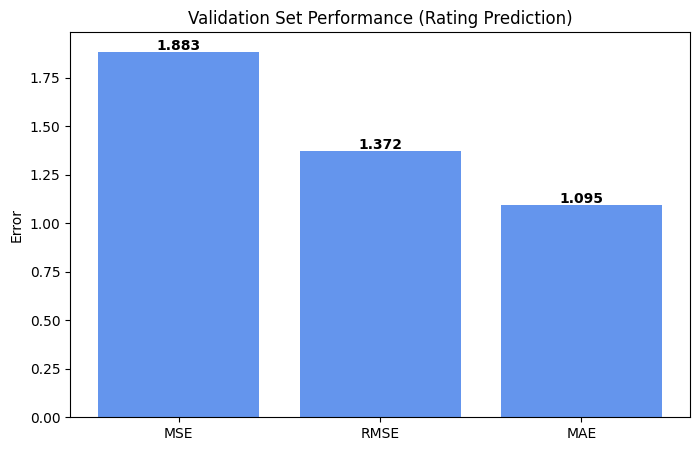

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

test_df = pd.read_csv("D:/Master/FSS_25/Web_Mining/Project/data/test_wide.csv")

# Load test set with true ratings
test_df_subset = test_df[['username', 'beer_id', 'taste_true_rating']]
eval_df = pd.merge(test_df_subset, pred_df, on=['username', 'beer_id'])

# Calculate prediction errors
mse = mean_squared_error(eval_df['taste_true_rating'], eval_df['predicted_rating'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(eval_df['taste_true_rating'], eval_df['predicted_rating'])

print(f"MSE: {mse:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"MAE: {mae:.3f}")

# Visualize error metrics
metrics = [mse, rmse, mae]
names = ['MSE', 'RMSE', 'MAE']

plt.figure(figsize=(8, 5))
plt.bar(names, metrics, color='cornflowerblue')
for i, val in enumerate(metrics):
    plt.text(i, val + 0.01, f"{val:.3f}", ha='center', fontweight='bold')
plt.ylabel("Error")
plt.title("Validation Set Performance (Rating Prediction)")
plt.ylim(0, max(metrics) + 0.1)
plt.show()

In [ ]:
# Top-N recommendation evaluation metrics (Precision@10, NDCG@10)
# Recommend top 10 beers for each user
recommendations = {}
for user, profile_vector in user_profiles.items():
    profile_vector = profile_vector.reshape(1, -1)
    sim_scores = cosine_similarity(profile_vector, beer_feature_df.values).flatten()
    sim_series = pd.Series(sim_scores, index=beer_feature_df.index)

    rated_beers = train_df[train_df['username'] == user]['beer_id'].tolist()
    sim_series = sim_series.drop(index=rated_beers, errors='ignore')

    top_beers = sim_series.sort_values(ascending=False).head(10).index.tolist()
    recommendations[user] = top_beers

# Ground truth from test set
ground_truth = test_df.groupby('username')['beer_id'].apply(set).to_dict()

# Precision@10
def precision_at_k(recommendations, ground_truth, k=10):
    precisions = []
    for user, rec_beers in recommendations.items():
        if user not in ground_truth:
            continue
        true_beers = ground_truth[user]
        hit_count = len(set(rec_beers[:k]) & true_beers)
        precisions.append(hit_count / k)
    return np.mean(precisions)

# NDCG@10
def ndcg_at_k(recommendations, ground_truth, k=10):
    def dcg(rels):
        return sum(rel / np.log2(idx + 2) for idx, rel in enumerate(rels))
    scores = []
    for user, rec_beers in recommendations.items():
        if user not in ground_truth:
            continue
        true_beers = ground_truth[user]
        relevance = [1 if beer in true_beers else 0 for beer in rec_beers[:k]]
        ideal_relevance = sorted(relevance, reverse=True)
        ndcg = dcg(relevance) / dcg(ideal_relevance) if sum(ideal_relevance) > 0 else 0.0
        scores.append(ndcg)
    return np.mean(scores)

# Output Top-N recommendation evaluation results
precision = precision_at_k(recommendations, ground_truth, k=10)
ndcg = ndcg_at_k(recommendations, ground_truth, k=10)

print(f"\nTop-N Evaluation:")
print(f"Precision@10: {precision:.4f}")
print(f"NDCG@10: {ndcg:.4f}")


Top-N Evaluation:
Precision@10: 0.0025
NDCG@10: 0.0125
